# AI Crypto Predictor

## Sujet : Prediction du prix du Bitcoin

Auteur : Elias Khallouk - 30/08/2025

---

### Importation des bibliothèques nécessaires

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score

### Définition des chemins vers le dataset

In [2]:
file_path = os.path.join("../data", "btcusd_1-min_data.csv")

### Chargement et aperçu des données

In [3]:
btc = pd.read_csv(file_path)

In [20]:
print(btc.head())
print(btc.info())
print(btc.columns)

                     Open  High   Low  Close  Volume
Timestamp                                           
2012-01-01 10:01:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:02:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:03:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:04:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:05:00  4.58  4.58  4.58   4.58     0.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7183836 entries, 2012-01-01 10:01:00 to 2025-08-29 23:56:00
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Open    float64
 1   High    float64
 2   Low     float64
 3   Close   float64
 4   Volume  float64
dtypes: float64(5)
memory usage: 328.8 MB
None
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


### Préparation des données

In [4]:
# Convertir la colonne "Date" en datetime
btc['Timestamp'] = pd.to_datetime(btc['Timestamp'], unit='s')
btc.set_index('Timestamp', inplace=True)

In [5]:
# Agréger par jour : prix moyen, min, max et volume total
btc_daily = btc.resample('1D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

In [7]:
print(btc_daily.head())

            Open  High   Low  Close      Volume
Timestamp                                      
2012-01-01  4.58  4.84  4.58   4.84   10.000000
2012-01-02  4.84  5.00  4.84   5.00   10.100000
2012-01-03  5.00  5.32  5.00   5.29  107.085281
2012-01-04  5.29  5.57  4.93   5.57  107.233260
2012-01-05  5.57  6.46  5.57   6.42   70.328742


In [8]:
print(btc_daily.tail())

                Open      High       Low     Close       Volume
Timestamp                                                      
2025-08-25  113491.0  113645.0  109283.0  110136.0  2458.058799
2025-08-26  110128.0  112400.0  108717.0  111788.0  1921.068400
2025-08-27  111789.0  112646.0  110381.0  111273.0  1115.692278
2025-08-28  111272.0  113473.0  110876.0  112581.0  1313.363125
2025-08-29  112581.0  112654.0  107488.0  108451.0  1974.994862


In [6]:
# Créer des features simples
btc_daily['Return'] = btc_daily['Close'].pct_change()       # Rendement quotidien
btc_daily['MA7'] = btc_daily['Close'].rolling(7).mean()     # Moyenne mobile 7 jours
btc_daily['MA30'] = btc_daily['Close'].rolling(30).mean()   # Moyenne mobile 30 jours
btc_daily['Volatility'] = btc_daily['Return'].rolling(7).std()  # Volatilité sur 7 jours

# RSI (14 jours)
delta = btc_daily['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
btc_daily['RSI'] = 100 - (100 / (1 + rs))

# MACD
ema12 = btc_daily['Close'].ewm(span=12, adjust=False).mean()
ema26 = btc_daily['Close'].ewm(span=26, adjust=False).mean()
btc_daily['MACD'] = ema12 - ema26
btc_daily['Signal'] = btc_daily['MACD'].ewm(span=9, adjust=False).mean()

# Bollinger Bands
ma20 = btc_daily['Close'].rolling(20).mean()
std20 = btc_daily['Close'].rolling(20).std()
btc_daily['Bollinger_Upper'] = ma20 + 2*std20
btc_daily['Bollinger_Lower'] = ma20 - 2*std20

# Créer la colonne Target : 1 si le prix du high de demain est supérieur de 50$ à l'ouverture d'aujourd'hui, sinon 0
btc_daily['Target'] = (btc_daily['High'].shift(-1) > (btc_daily['Open'] + 50)).astype(int)
btc_daily = btc_daily.dropna() # Retirer la dernière ligne car elle n'a pas de valeur pour Target

In [7]:
# Supprimer les lignes avec NaN (les premières lignes des rolling)
btc_daily.dropna(inplace=True)

In [11]:
print(btc_daily.tail())

                Open      High       Low     Close       Volume    Return  \
Timestamp                                                                   
2025-08-25  113491.0  113645.0  109283.0  110136.0  2458.058799 -0.029451   
2025-08-26  110128.0  112400.0  108717.0  111788.0  1921.068400  0.015000   
2025-08-27  111789.0  112646.0  110381.0  111273.0  1115.692278 -0.004607   
2025-08-28  111272.0  113473.0  110876.0  112581.0  1313.363125  0.011755   
2025-08-29  112581.0  112654.0  107488.0  108451.0  1974.994862 -0.036685   

                      MA7           MA30  Volatility        RSI         MACD  \
Timestamp                                                                      
2025-08-25  113643.142857  116265.533333    0.024878  35.505679  -861.712160   
2025-08-26  113488.571429  116009.500000    0.024030  36.061124 -1033.766641   
2025-08-27  113061.428571  115783.566667    0.023289  27.701730 -1197.868965   
2025-08-28  113077.000000  115605.400000    0.023217  37.602

In [8]:
# Split train/test
split_date = '2023-05-01'
train = btc_daily[btc_daily.index < split_date]
test = btc_daily[btc_daily.index >= split_date]

print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (4109, 15), Test shape: (852, 15)


In [9]:
# Variables explicatives (toutes les colonnes sauf Target)
X_train = train.drop(columns=["Target"])
X_test = test.drop(columns=["Target"])

# Variable cible (ce qu’on veut prédire : Target)
y_train = train["Target"]
y_test = test["Target"]


In [14]:
print(X_train.tail())
print(X_train.info())

               Open     High      Low    Close       Volume    Return  \
Timestamp                                                               
2023-04-26  27629.0  30022.0  27625.0  27897.0  4277.067899  0.010322   
2023-04-27  27891.0  29887.0  27242.0  29662.0  4730.882350  0.063268   
2023-04-28  29701.0  29787.0  28922.0  29337.0  2896.603040 -0.010957   
2023-04-29  29338.0  29460.0  29061.0  29267.0   941.112767 -0.002386   
2023-04-30  29262.0  29961.0  29115.0  29383.0  1361.944150  0.003964   

                     MA7          MA30  Volatility        RSI        MACD  \
Timestamp                                                                   
2023-04-26  27622.000000  28604.600000    0.020366  35.007083   -6.585148   
2023-04-27  27846.285714  28679.100000    0.028206  45.354685  108.726683   
2023-04-28  28140.857143  28709.766667    0.024853  43.606057  171.905733   
2023-04-29  28375.142857  28752.766667    0.025297  43.034291  213.861904   
2023-04-30  28648.285714  

In [15]:
print(y_train.tail())
print(y_train.info())

Timestamp
2023-04-26    1
2023-04-27    1
2023-04-28    0
2023-04-29    1
2023-04-30    1
Freq: D, Name: Target, dtype: int64
<class 'pandas.core.series.Series'>
DatetimeIndex: 4109 entries, 2012-01-30 to 2023-04-30
Freq: D
Series name: Target
Non-Null Count  Dtype
--------------  -----
4109 non-null   int64
dtypes: int64(1)
memory usage: 64.2 KB
None


### Visualisation 

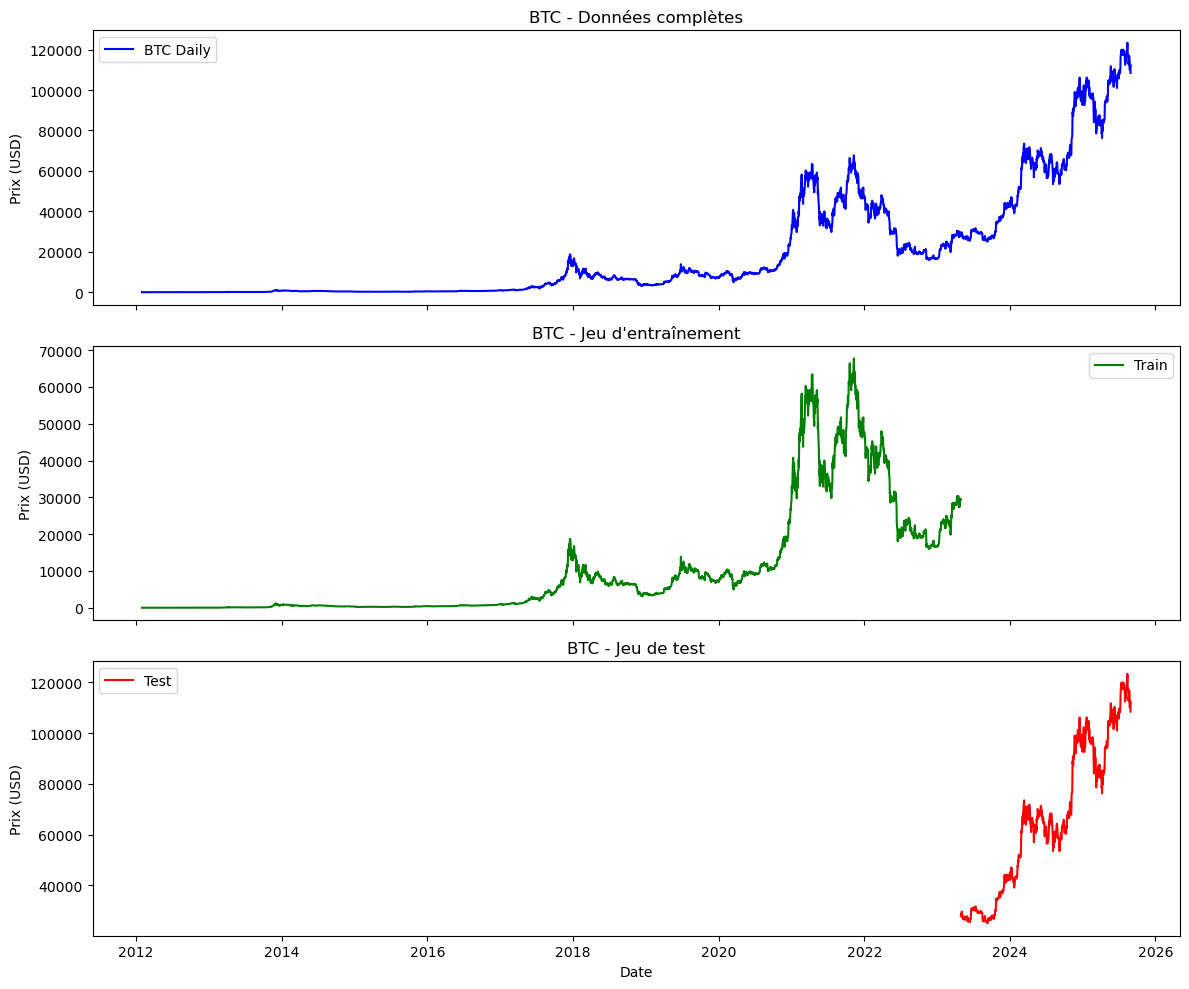

In [17]:
# Créer une figure avec 3 sous-graphes (partage de l'axe X = mêmes dates)
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# 1. Graphique complet
axs[0].plot(btc_daily.index, btc_daily['Close'], color="blue", label="BTC Daily")
axs[0].set_title("BTC - Données complètes")
axs[0].set_ylabel("Prix (USD)")
axs[0].legend()

# 2. Train set
axs[1].plot(train.index, train['Close'], color="green", label="Train")
axs[1].set_title("BTC - Jeu d'entraînement")
axs[1].set_ylabel("Prix (USD)")
axs[1].legend()

# 3. Test set
axs[2].plot(test.index, test['Close'], color="red", label="Test")
axs[2].set_title("BTC - Jeu de test")
axs[2].set_xlabel("Date")
axs[2].set_ylabel("Prix (USD)")
axs[2].legend()

# Ajuster l'espacement
plt.tight_layout()
plt.show()


### Pipeline de test

In [20]:
features = ['Return','MA7','MA30','Volatility','RSI','MACD','Signal','Bollinger_Upper','Bollinger_Lower']
X_train = train[features]
y_train = train['Target']
X_test = test[features]
y_test = test['Target']


In [10]:

model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [11]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8568075117370892
              precision    recall  f1-score   support

           0       0.75      0.56      0.64       196
           1       0.88      0.95      0.91       656

    accuracy                           0.86       852
   macro avg       0.82      0.75      0.78       852
weighted avg       0.85      0.86      0.85       852



In [13]:

# Modèle XGBoost avec poids équilibrés
model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train[y_train==0]) / len(y_train[y_train==1]))
)

# Entraînement
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Résultats
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.863849765258216
              precision    recall  f1-score   support

           0       0.75      0.61      0.67       196
           1       0.89      0.94      0.91       656

    accuracy                           0.86       852
   macro avg       0.82      0.77      0.79       852
weighted avg       0.86      0.86      0.86       852



### Conception du modèle de réseau de neurones profond

In [1]:
"""from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))  # Output layer for predicting the target

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model
    """

"from tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import LSTM, Dense, Dropout\nfrom tensorflow.keras.optimizers import Adam\n\ndef create_lstm_model(input_shape):\n    model = Sequential()\n    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))\n    model.add(Dropout(0.2))\n    model.add(LSTM(50, return_sequences=False))\n    model.add(Dropout(0.2))\n    model.add(Dense(25))\n    model.add(Dense(1))  # Output layer for predicting the target\n\n    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')\n    return model\n    "

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Conversion numpy → tensor
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Réseau simple (MLP)
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)

model = MLP(input_dim=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/50], Loss: {loss.item():.4f}")

# Test
model.eval()
with torch.no_grad():
    preds = model(X_test_t).round()
    acc = accuracy_score(y_test, preds)
    print("Accuracy MLP:", acc)


ValueError: could not determine the shape of object type 'DataFrame'

In [20]:
# ----------------------
# 2. Modèle MLP (réseau dense classique)
# ----------------------
mlp = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

mlp.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history_mlp = mlp.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Évaluation du modèle sur le jeu de test
test_loss, test_acc = mlp.evaluate(X_test, y_test)
print("Précision sur le jeu de test : {:.2f}%".format(test_acc * 100))

Epoch 1/20


/home/elias/anaconda3/envs/crypto_predictor/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6525 - loss: 578.0291 - val_accuracy: 0.7793 - val_loss: 36.0134
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6702 - loss: 138.4557 - val_accuracy: 0.7465 - val_loss: 25.2868
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6461 - loss: 45.5419 - val_accuracy: 0.7664 - val_loss: 0.7870
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6410 - loss: 14.9781 - val_accuracy: 0.2300 - val_loss: 0.7395
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6201 - loss: 7.1159 - val_accuracy: 0.2300 - val_loss: 0.7550
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6364 - loss: 3.1111 - val_accuracy: 0.2300 - val_loss: 0.7734
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6364 - loss: 3.1834 - val_accuracy: 0.2300 - val_loss: 0.7924
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6437 - loss: 1.5142 - val_accuracy: 0.230

In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
# ----------------------
# 3. Modèle LSTM (séquentiel, capture la dynamique temporelle)
# ----------------------

# Reshape des données pour LSTM : (échantillons, timesteps, features)
# Ici on prend un pas de temps de 10 jours (fenêtre glissante)
timesteps = 10
def create_sequences(X, y, timesteps=10):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:(i+timesteps)])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

X_lstm, y_lstm = create_sequences(X_scaled, y_train.values, timesteps)

# Split train/test
split = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]

# Construction du LSTM
lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(timesteps, X_train.shape[1])),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history_lstm = lstm.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20


/home/elias/anaconda3/envs/crypto_predictor/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7563 - loss: 0.4671 - val_accuracy: 0.7427 - val_loss: 0.5707
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8253 - loss: 0.3844 - val_accuracy: 0.7427 - val_loss: 0.5735
Epoch 3/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8292 - loss: 0.3753 - val_accuracy: 0.7427 - val_loss: 0.5753
Epoch 4/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8365 - loss: 0.3695 - val_accuracy: 0.7427 - val_loss: 0.5739
Epoch 5/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8371 - loss: 0.3640 - val_accuracy: 0.7427 - val_loss: 0.5793
Epoch 6/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8390 - loss: 0.3623 - val_accuracy: 0.7427 - val_loss: 0.5769
Epoch 7/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8381 - loss: 0.3627 - val_accuracy: 0.7427 - val_loss: 0.5731
Epoch 8/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8365 - loss: 0.3662 - val_accuracy: 0.7427 - val_

In [40]:
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Rapport completu
print(classification_report(y_test, y_pred))

# Matrice de confusion
print(confusion_matrix(y_test, y_pred))


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.7699530516431925
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       196
           1       0.77      1.00      0.87       656

    accuracy                           0.77       852
   macro avg       0.38      0.50      0.44       852
weighted avg       0.59      0.77      0.67       852

[[  0 196]
 [  0 656]]


/home/elias/anaconda3/envs/crypto_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/elias/anaconda3/envs/crypto_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/elias/anaconda3/envs/crypto_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

AUC: 0.5


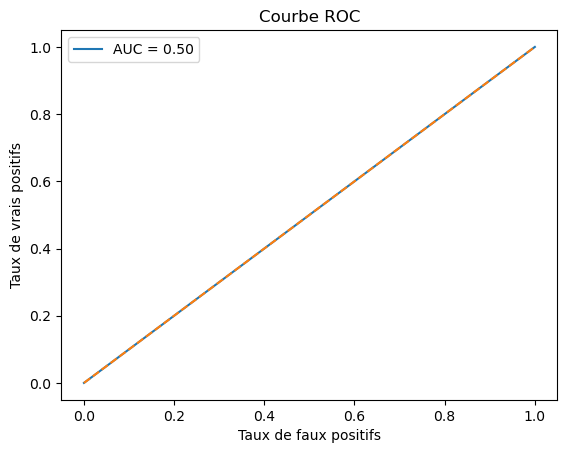

In [41]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# AUC
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC:", auc)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()


In [10]:
# Création d'un jeu de validation à partir de X_train et y_train
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [24]:
print(X_train_split.head())
print(X_train_split.info())

                Open      High       Low     Close        Volume    Return  \
Timestamp                                                                    
2018-11-30   4214.55   4300.00   3861.00   3970.20  15375.268113 -0.058641   
2014-06-12    636.25    636.30    602.50    604.00  10517.560360 -0.050090   
2023-02-27  23490.00  23890.00  23170.00  23290.00   1783.271322 -0.008050   
2020-10-15  11348.62  11543.78  11250.01  11532.98   4320.267630  0.015894   
2023-01-22  23266.00  23310.00  22615.00  22838.00   1439.470812 -0.017847   

                     MA7          MA30  Volatility        RSI         MACD  \
Timestamp                                                                    
2018-11-30   3980.537143   5361.897333    0.079861  23.823307  -586.276147   
2014-06-12    642.634286    570.470333    0.018260  59.195808    34.696824   
2023-02-27  23591.857143  23293.566667    0.020700  60.753182   350.993124   
2020-10-15  11367.755714  10865.390333    0.014897  74.444409  

In [45]:
from keras import Input, Model
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

# Définition explicite de l'entrée
inputs = Input(shape=(14,))
x = Dense(256, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Couche de sortie : 2 classes
outputs = Dense(1, activation='sigmoid')(x)

# Création du modèle final
model = Model(inputs=inputs, outputs=outputs)

# Compilation
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Résumé
model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 256)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,897 (316.00 KB)

 Trainable params: 79,489 (310.50 KB)

 Non-trainable params: 1,408 (5.50 KB)

In [48]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcul des poids de classes
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_split),
    y=y_train_split
)
class_weights = dict(enumerate(class_weights))

# Entraînement avec poids
history = model.fit(
    X_train_split, y_train_split, 
    epochs=50, batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    class_weight=class_weights
)

# Évaluation du modèle sur le jeu de test
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Précision sur le jeu de test : {:.2f}%".format(test_acc * 100))

# Seuil ajusté pour limiter faux positifs
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.7).astype(int)

Epoch 1/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8013 - loss: 0.4553 - val_accuracy: 0.8236 - val_loss: 0.4052
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8029 - loss: 0.4466 - val_accuracy: 0.8236 - val_loss: 0.4188
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8038 - loss: 0.4387 - val_accuracy: 0.8200 - val_loss: 0.4153
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8041 - loss: 0.4384 - val_accuracy: 0.8236 - val_loss: 0.4028
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7998 - loss: 0.4438 - val_accuracy: 0.8236 - val_loss: 0.4182
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8032 - loss: 0.4383 - val_accuracy: 0.8273 - val_loss: 0.3932
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8059 - loss: 0.4433 - val_accuracy: 0.8236 - val_loss: 0.4058
Epoch 8/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8038 - loss: 0.4437 - val_accuracy: 0.

In [21]:
from keras import Input, Model
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Définition explicite de l'entrée
inputs = Input(shape=(14,))
x = Dense(256, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Sortie binaire
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compilation
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entraînement
history = model.fit(
    X_train_split, y_train_split,
    epochs=100, batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    class_weight={0: 1, 1: 2}  # pénalise plus les faux positifs (classe 1)
)


# Évaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Précision sur test : {:.2f}%".format(test_acc * 100))
"""
# Seuil ajusté pour limiter faux positifs
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.7).astype(int)


# Évaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Précision sur test : {:.2f}%".format(test_acc * 100))"""


# Prédictions en probabilités (entre 0 et 1)
y_pred_proba = model.predict(X_test)

# On change le seuil -> ici 0.9 au lieu de 0.5
threshold = 0.9
y_pred = (y_pred_proba > threshold).astype(int)

# Évaluation
print("Rapport de classification (seuil = 0.9):")
print(classification_report(y_test, y_pred, digits=4))

print("Précision de la classe 1:", precision_score(y_test, y_pred))
print("Recall de la classe 1:", recall_score(y_test, y_pred))

Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6453 - loss: 0.9729 - val_accuracy: 0.8114 - val_loss: 0.5045
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7402 - loss: 0.7933 - val_accuracy: 0.8236 - val_loss: 0.4524
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7667 - loss: 0.7312 - val_accuracy: 0.8236 - val_loss: 0.4451
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7782 - loss: 0.7295 - val_accuracy: 0.8248 - val_loss: 0.4484
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7776 - loss: 0.6914 - val_accuracy: 0.8236 - val_loss: 0.4501
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7737 - loss: 0.6958 - val_accuracy: 0.8248 - val_loss: 0.4438
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7807 - loss: 0.6624 - val_accuracy: 0.8248 - val_loss: 0.4496
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7822 - loss: 0.6673 - val_accu

In [22]:
# Affichage du rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred))


Rapport de classification :
              precision    recall  f1-score   support

           0       0.40      0.91      0.55       196
           1       0.96      0.59      0.73       656

    accuracy                           0.66       852
   macro avg       0.68      0.75      0.64       852
weighted avg       0.83      0.66      0.69       852



In [27]:
X_test

,Open,High,Low,Close,Volume,Return,MA7,MA30,Volatility,RSI,MACD,Signal,Bollinger_Upper,Bollinger_Lower
Timestamp,,,,,,,,,,,,,,
2023-05-01,29374.0,29504.0,27783.0,27821.0,2712.240936,-0.053160,28711.285714,28764.300000,0.034386,40.509099,157.151102,236.424419,31271.441218,26625.758782
2023-05-02,27809.0,28894.0,27666.0,28708.0,2070.476951,0.031882,28867.857143,28789.033333,0.036125,41.320155,150.591889,219.257913,31183.409890,26604.390110
2023-05-03,28705.0,28836.0,28138.0,28331.0,2453.413130,-0.013132,28929.857143,28796.800000,0.036754,44.418661,113.662683,198.138867,30985.436663,26599.063337
2023-05-04,28324.0,29378.0,28297.0,28902.0,2127.946223,0.020155,28821.285714,28820.166667,0.027334,55.324744,128.984101,184.307914,30790.310347,26650.189653
2023-05-05,28907.0,29701.0,28767.0,29586.0,1980.368115,0.023666,28856.857143,28864.433333,0.028825,65.462331,194.082259,186.262783,30647.087759,26715.212241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-25,113491.0,113645.0,109283.0,110136.0,2458.058799,-0.029451,113643.142857,116265.533333,0.024878,35.505679,-861.712160,-148.136529,122434.060904,110542.039096
2025-08-26,110128.0,112400.0,108717.0,111788.0,1921.068400,0.015000,113488.571429,116009.500000,0.024030,36.061124,-1033.766641,-325.262551,122606.672368,110045.227632
2025-08-27,111789.0,112646.0,110381.0,111273.0,1115.692278,-0.004607,113061.428571,115783.566667,0.023289,27.701730,-1197.868965,-499.783834,122655.755791,109371.944209


In [28]:
btc_daily

,Open,High,Low,Close,Volume,Return,MA7,MA30,Volatility,RSI,MACD,Signal,Bollinger_Upper,Bollinger_Lower,Target
Timestamp,,,,,,,,,,,,,,,
2012-01-30,5.90,5.90,5.30,5.58,22.380000,-0.054237,5.870000,6.340333,0.116844,38.087774,-0.068881,0.130719,7.674344,5.266656,0
2012-01-31,5.58,6.22,5.55,5.55,104.718333,-0.005376,5.727143,6.364000,0.116607,39.130435,-0.104298,0.083716,7.641570,5.154430,0
2012-02-01,5.55,6.00,3.80,5.99,13.552446,0.079279,5.725714,6.397000,0.117473,41.395349,-0.095758,0.047821,7.627398,5.116602,0
2012-02-02,5.99,6.26,5.54,6.26,123.582638,0.045075,5.724286,6.429333,0.117477,52.220249,-0.066438,0.024969,7.571123,5.108877,0
2012-02-03,6.26,6.35,5.93,6.29,283.382106,0.004792,5.782857,6.453333,0.113701,43.008475,-0.040316,0.011912,7.565477,5.103523,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-25,113491.00,113645.00,109283.00,110136.00,2458.058799,-0.029451,113643.142857,116265.533333,0.024878,35.505679,-861.712160,-148.136529,122434.060904,110542.039096,0
2025-08-26,110128.00,112400.00,108717.00,111788.00,1921.068400,0.015000,113488.571429,116009.500000,0.024030,36.061124,-1033.766641,-325.262551,122606.672368,110045.227632,1
2025-08-27,111789.00,112646.00,110381.00,111273.00,1115.692278,-0.004607,113061.428571,115783.566667,0.023289,27.701730,-1197.868965,-499.783834,122655.755791,109371.944209,1


In [31]:
import pandas as pd
import numpy as np

# --- Étape 1 : créer un DataFrame avec les nouvelles données ---
# On suppose que tu as déjà des anciennes données pour calculer les features glissantes (MA7, RSI, etc.)
# Sinon, il faut minimum 30 jours de données pour calculer toutes les features correctement

new_data = {
    'Open': [112581.00],
    'High': [112654.00],
    'Low': [107488.00],
    'Close': [108451.00	],
    'Volume': [1974.994862]
}

df_new = pd.DataFrame(new_data)

# Si tu veux, tu peux concaténer les nouvelles données à ton ancien dataset pour calculer les indicateurs correctement
btc_temp = pd.concat([btc_daily[['Open','High','Low','Close','Volume']], df_new], ignore_index=True)

# --- Étape 2 : calculer les features ---
btc_temp['Return'] = btc_temp['Close'].pct_change()
btc_temp['MA7'] = btc_temp['Close'].rolling(7).mean()
btc_temp['MA30'] = btc_temp['Close'].rolling(30).mean()
btc_temp['Volatility'] = btc_temp['Return'].rolling(7).std()

delta = btc_temp['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
btc_temp['RSI'] = 100 - (100 / (1 + rs))

ema12 = btc_temp['Close'].ewm(span=12, adjust=False).mean()
ema26 = btc_temp['Close'].ewm(span=26, adjust=False).mean()
btc_temp['MACD'] = ema12 - ema26
btc_temp['Signal'] = btc_temp['MACD'].ewm(span=9, adjust=False).mean()

ma20 = btc_temp['Close'].rolling(20).mean()
std20 = btc_temp['Close'].rolling(20).std()
btc_temp['Bollinger_Upper'] = ma20 + 2*std20
btc_temp['Bollinger_Lower'] = ma20 - 2*std20

# --- Étape 3 : ne garder que la dernière ligne (celle qu'on veut prédire) ---
X_manual = btc_temp.iloc[[-1]][
    ['Open','High','Low','Close','Volume','Return','MA7','MA30','Volatility',
     'RSI','MACD','Signal','Bollinger_Upper','Bollinger_Lower']
]

# --- Étape 4 : appliquer le scaler utilisé pour l'entraînement ---
#X_manual_scaled = scaler.transform(X_manual.values)

# --- Étape 5 : prédiction avec seuil ---
y_pred_proba = model.predict(X_manual.values)
threshold = 0.9
y_pred = (y_pred_proba > threshold).astype(int)

print("Probabilité:", y_pred_proba[0][0])
print("Prédiction (0 ou 1):", y_pred[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Probabilité: 0.7423278
Prédiction (0 ou 1): 0


In [ ]:
print(btc['Timestamp'].iloc[-1])